In [27]:
import numpy as np
from joblib import load
from scipy.sparse import vstack, hstack, csr_matrix
from scipy.stats import sem
from sklearn.model_selection import cross_validate, RepeatedKFold
from sklearn.metrics import precision_score, roc_auc_score

In [28]:
data = load('./data/gp_comments/data_vectorized_revealed_25k_0.sav')
data_headers_dict = load('./data/gp_comments/data_headers_0.sav')['vocabulary_']
labels = load('./data/gp_comments/labels_revealed_25k_0.sav')
print(len(data))
print(len(labels))
print(len(data_headers_dict))

25000
25000
2511


In [29]:
labels = np.asarray(labels, dtype=object)
print(len(labels))

data = np.array(data)
print(len(data))

headers = sorted(data_headers_dict.keys(), key=lambda key: data_headers_dict[key])
headers_concurrent = list(map(lambda h: f'{h}_concurrent', headers))
print(len(headers), len(headers_concurrent))

25000
25000
2511 2511


In [30]:
def reveal_spase(sparse_list):
    return vstack(sparse_list, format='csr')

def reveal_np(np_list):
    return np.concatenate(np_list, axis=0)

def reveal_set(data_, labels_):
    return reveal_spase(data_), reveal_np(labels_)

In [31]:
class CustomEstimator:
    def __init__(self, model=None):
        self.model = model

    def fit(self, X, Y=None):
        train_data_revealed, train_labels_revealed = reveal_set(X, Y)
        self.model.fit(train_data_revealed, train_labels_revealed)

        return self

    def get_params(self, deep=False):
        return {'model': self.model}

In [32]:
def evaluate(estimator, test_data_list, test_labels_list):
    """Evaluate estimator on each document from `test_data_list`

    :param estimator: sklearn estimator
    :param test_data_list: list of sparce matrices
    :param test_labels_list: 2d list of labels
    :return: precision and roc-auc scores (calculates by macro-averaging corresponding scores of each document)
    """
    precision_batch = []
    roc_auc_batch = []
    for test_data_batch, test_labels_batch in zip(test_data_list, test_labels_list):
        positive_class_proba = estimator.model.predict_proba(test_data_batch)[:, 1]

        max_p_idx = np.argmax(positive_class_proba)
        predicted_labels_batch = [0] * len(positive_class_proba)
        predicted_labels_batch[max_p_idx] = 1
        if len(test_labels_batch) == 1:
            print(test_labels_batch)
        precision_batch.append(precision_score(test_labels_batch, predicted_labels_batch))
        roc_auc_batch.append(roc_auc_score(test_labels_batch, positive_class_proba))

    return {
        'precision': np.average(precision_batch),
        'roc-auc': np.average(roc_auc_batch)
    }

In [43]:
def repeated_cross_validation(estimator, X, y, k=10, r=3, random_state=42, verbose=1):
    cv = RepeatedKFold(n_splits=k, n_repeats=r, random_state=random_state)
    result = cross_validate(
        estimator=estimator,
        X=X,
        y=y,
        scoring=evaluate,
        cv=cv,
        n_jobs=-1,
        verbose=verbose,
        return_train_score=True,
        return_estimator=True,
        error_score='raise',
    )

    return result

In [34]:
def statistics_from_cv(cv_result):
    scores_precision = cv_result['test_precision']
    scores_roc_auc = cv_result['test_roc-auc']

    return {
        'precision mean': np.mean(scores_precision),
        'precision sem': sem(scores_precision),
        'roc-auc mean': np.mean(scores_roc_auc),
        'roc-auc sem': sem(scores_roc_auc),
    }

In [35]:
def enumerate_repeats(estimator, X, y, from_=1, to=11, k=10, random_state=42):
    print("%3s %15s %15s %15s %15s" % ('r', 'roc-auc mean', 'roc-auc sem', 'precision mean', 'precision sem'))
    for r in range(from_, to):
        cv_results = repeated_cross_validation(estimator, X, y, random_state=random_state, r=r, k=k, verbose=0)
        stats = statistics_from_cv(cv_results)

        print("%3d %15.10f %15.10f %15.10f %15.10f" % (
            r, stats['roc-auc mean'], stats['roc-auc sem'], stats['precision mean'], stats['precision sem']))

In [42]:
def compare_estimator(estimator, data_base, data_concurrent_, labels_, k=10, r=3):
    cv_results_base = repeated_cross_validation(estimator, data_base, labels_, verbose=1, r=r, k=k)
    stats_base = statistics_from_cv(cv_results_base)

    cv_results_concurrent = repeated_cross_validation(estimator, data_concurrent_, labels_, verbose=1,  r=r, k=k)
    stats_concurrent = statistics_from_cv(cv_results_concurrent)

    return {
        'base': stats_base,
        'concurrent': stats_concurrent,
    }

In [37]:
def doc_concurrent_data(doc):
    concurrent_list = []
    n = doc.shape[0]
    for idx, candidate in enumerate(doc):
        concurrent_mask = [True] * n
        concurrent_mask[idx] = False
        concurrent_candidates = doc[concurrent_mask]
        concurrent = concurrent_candidates.sum(axis=0)
        # concurrent[concurrent > 0] = 1  # binarize matrix
        concurrent = csr_matrix(concurrent)
        concurrent_list.append(concurrent)

    concurrent_sparse = reveal_spase(concurrent_list)
    result = hstack([doc, concurrent_sparse], format='csr')

    return result

In [38]:
data_concurrent = list(map(doc_concurrent_data, data))

In [39]:
data_concurrent[0].shape

(24, 5022)

In [40]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight='balanced', verbose=1, warm_start=False, n_jobs=-1)
estimator_mnb = CustomEstimator(model)

In [41]:
enumerate_repeats(estimator_mnb, data, labels)

  r    roc-auc mean     roc-auc sem  precision mean   precision sem
  1    0.9441441503    0.0010461323    0.8099200000    0.0028238980
  2    0.9446006316    0.0008058943    0.8110800000    0.0024221956
  3    0.9444217468    0.0006304719    0.8109200000    0.0017373411
  4    0.9442614172    0.0005333794    0.8103600000    0.0014188330


KeyboardInterrupt: 

In [44]:
result_log_reg = compare_estimator(estimator_mnb, data, data_concurrent, labels)
result_log_reg

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.5min finished


{'base': {'precision mean': 0.8109199999999999,
  'precision sem': 0.0017373410784841607,
  'roc-auc mean': 0.944421746810861,
  'roc-auc sem': 0.0006304718623796982},
 'concurrent': {'precision mean': 0.8806266666666667,
  'precision sem': 0.0012768759769595465,
  'roc-auc mean': 0.9658310229628024,
  'roc-auc sem': 0.0005285297414779061}}

In [48]:
cv_results = result_log_reg['concurrent']
best_estimator_idx = np.argmax(cv_results['precision mean'])
best_estimator = cv_results['estimator'][best_estimator_idx]

KeyError: 'estimator'

In [47]:
headers_full = np.concatenate((headers, headers_concurrent))
header_coef = zip(best_estimator.model.coef_[0], headers_full)
header_coef_sorted = list(sorted(header_coef, reverse=True))

NameError: name 'best_estimator' is not defined

In [ ]:
header_coef_sorted[:10], header_coef_sorted[-10:]

In [110]:
c1 = best_estimator.model.coef_[0][:4135]
c2 = best_estimator.model.coef_[0][4135:]
count = 0
total = 0
for h, p1, p2 in zip(headers, c1, c2):
    if p1 < -0.1:
        total += 1
        if p2 > 0:
            count+=1
            # print(h, p1, p2)
        else:
            print(p1, p2)
print(count / total)

-0.17925402897869513 -0.050395103921137156
-0.12843381731444184 -0.011594832452895519
-0.17455437135508886 -0.08572823707320594
-0.1051885632791977 -0.04256704660684643
-0.13777004643477417 -0.0295081920066722
-0.10794076856921966 -0.11108480880631763
-0.12106849053203383 -0.001708891913621283
-0.23776681131665608 -0.03376477541104234
-0.13823044018056627 -0.08694133590910838
-0.2145477687068512 -0.037108002613075966
-0.1736312062294188 -0.061206208468859574
-0.16623839912424276 -0.06138633410565196
-0.11958180820992567 -0.03582245400557444
-0.12888783445621543 -0.009348883568772672
-0.1862843574509111 -0.12459102485913086
-0.1277374519052441 -0.06604105510380967
-0.1599998980236865 -0.05773107743347218
-0.15048889127514017 -0.0517832187860457
-0.12008198010059036 -0.052984293459078555
-0.11435170036315408 -0.003518686880286604
0.8863636363636364


In [94]:
total

364

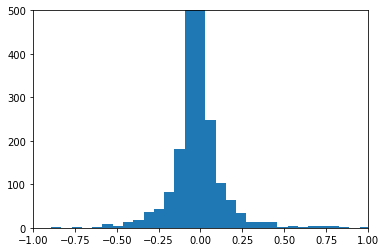

<Figure size 1440x1440 with 0 Axes>

In [89]:
from matplotlib import pyplot as plt
plt.hist(c1, bins=50,)
plt.ylim(0, 500)
plt.xlim(-1, 1)
plt.figure(figsize=(20, 20))
plt.show()

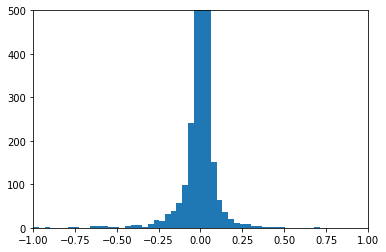

<Figure size 1440x1440 with 0 Axes>

In [90]:
from matplotlib import pyplot as plt
plt.hist(c2, bins=50)
plt.ylim(0, 500)
plt.xlim(-1, 1)
plt.figure(figsize=(20, 20))
plt.show()